In [1]:
import numpy as np
from numpy import arange
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read Data

In [7]:
ebay = pd.read_excel("ebayAuctions.xlsx", sheet_name=1)

In [8]:
ebay.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [9]:
ebay.shape

(1972, 8)

In [10]:
ebay.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568
std,5973.011033,2.052906,89.493858,38.856149,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000
max,37727.000000,10.000000,999.000000,999.000000,1.000000


In [11]:
ebay.dtypes

Category         object
Currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive?      int64
dtype: object

In [12]:
ebay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [13]:
ebay['Category'].value_counts()

Category
Music/Movie/Game        403
Collectibles            239
Toys/Hobbies            234
Automotive              178
Antique/Art/Craft       177
SportingGoods           124
Clothing/Accessories    119
Home/Garden             102
Jewelry                  82
Health/Beauty            64
Electronics              55
Books                    54
Coins/Stamps             37
Computer                 36
Pottery/Glass            20
Business/Industrial      18
EverythingElse           17
Photography              13
Name: count, dtype: int64

In [14]:
ebay['Currency'].value_counts()

Currency
US     1292
EUR     533
GBP     147
Name: count, dtype: int64

In [15]:
ebay['sellerRating'].value_counts()

sellerRating
3249     128
2349      92
3385      82
5701      56
27132     46
        ... 
5703       1
107        1
79         1
2956       1
510        1
Name: count, Length: 461, dtype: int64

In [16]:
ebay['Duration'].value_counts()

Duration
7     967
5     466
10    303
3     213
1      23
Name: count, dtype: int64

In [17]:
ebay['endDay'].value_counts()

endDay
Mon    548
Sat    351
Sun    338
Fri    287
Thu    202
Tue    171
Wed     75
Name: count, dtype: int64

In [18]:
ebay['Competitive?'].value_counts()

Competitive?
1    1066
0     906
Name: count, dtype: int64

### Summary of findings about the data

 - There's no missing data. The sample size is 1972 and there are 8 variables.
 - `Competitive?` is a binary variable (0 = not competitive, 1 = competitive). Maybe want to convert to factors.
 - `Currency` has 3 different categories and `ClosePrice`, `OpenPrice` are likely to be linked to the currency units. So we may want to convert into the same currency unit.
 - `Category`, `Currency`, `Duration`, and `endDay` seem to be categorical variables. We may need to use OneHotEncoding when preprocessing data.

## KNN Model Fitting

### 1. Converting the Currency Units Based on Exchange Rates
First of all, we want to keep the same currency unit for the `OpenPrice` and `ClosePrice`. We choose the currency unit to be in USD because we observed that most of the observations are in USD. We will create two new columns `OpenPriceUSD` and `ClosePriceUSD` that contain the converted prices in USD. By doing so, we can drop the original `Currency`, `OpenPrice`, and `ClosePrice` columns since the information they contain are now represented by the two newly created columns. We will use the exchange rates on Sep. 29, 2025 for our conversion.

In [19]:
rates = {"US": 1.00, "EUR": 1.17, "GBP": 1.34}
ebay["OpenPriceUSD"] = ebay.apply(lambda row: row["OpenPrice"] * rates[row["Currency"]], axis=1)
ebay["ClosePriceUSD"]  = ebay.apply(lambda row: row["ClosePrice"]  * rates[row["Currency"]], axis=1)

In [20]:
# Check if the conversion is correct
ebay.loc[ebay['Currency'] == "EUR"].head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,OpenPriceUSD,ClosePriceUSD
193,Electronics,EUR,9,5,Sun,1.23,1.23,0,1.4391,1.4391
195,Antique/Art/Craft,EUR,158,5,Mon,1.23,1.23,0,1.4391,1.4391
196,Books,EUR,410,5,Mon,1.23,1.23,0,1.4391,1.4391
197,Books,EUR,666,5,Thu,1.23,1.23,0,1.4391,1.4391
198,Books,EUR,865,5,Fri,1.23,1.23,0,1.4391,1.4391


In [21]:
ebay.loc[ebay['Currency'] == 'GBP'].head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?,OpenPriceUSD,ClosePriceUSD
106,Home/Garden,GBP,29,7,Thu,11.60,0.02,1,0.0268,15.5440
137,Home/Garden,GBP,2991,7,Thu,0.98,0.53,1,0.7102,1.3132
146,Music/Movie/Game,GBP,1029,7,Thu,1.07,1.07,0,1.4338,1.4338
147,Music/Movie/Game,GBP,1029,7,Thu,1.07,1.07,0,1.4338,1.4338
148,Toys/Hobbies,GBP,2991,7,Thu,2.14,0.53,1,0.7102,2.8676


### 2. Applying Log Transformation on Numeric Variables with Outliers

From EDA section, we noticed that there are many outliers in the numeric columns `OpenPrcie`, `ClosePrice`. To address the issue, we apply log transformation on these variables. In the end, we will store the log-transformed prices in two columns `logOpenPrice` and `logClosePrice`, and drop the original columns that are not needed anymore.

In [22]:
ebay["logOpenPriceUSD"] = np.log(ebay["OpenPriceUSD"])
ebay["logClosePriceUSD"] = np.log(ebay["ClosePriceUSD"])

In [23]:
ebay.drop(columns=['Currency', 'ClosePrice', 'OpenPrice', 'OpenPriceUSD', 'ClosePriceUSD'], inplace=True)

In [24]:
ebay.head()

,Category,sellerRating,Duration,endDay,Competitive?,logOpenPriceUSD,logClosePriceUSD
0,Music/Movie/Game,3249,5,Mon,0,-4.60517,-4.60517
1,Music/Movie/Game,3249,5,Mon,0,-4.60517,-4.60517
2,Music/Movie/Game,3249,5,Mon,0,-4.60517,-4.60517
3,Music/Movie/Game,3249,5,Mon,0,-4.60517,-4.60517
4,Music/Movie/Game,3249,5,Mon,0,-4.60517,-4.60517


sellerRating           Axes(0.125,0.653529;0.352273x0.226471)
Duration            Axes(0.547727,0.653529;0.352273x0.226471)
Competitive?           Axes(0.125,0.381765;0.352273x0.226471)
logOpenPriceUSD     Axes(0.547727,0.381765;0.352273x0.226471)
logClosePriceUSD           Axes(0.125,0.11;0.352273x0.226471)
dtype: object

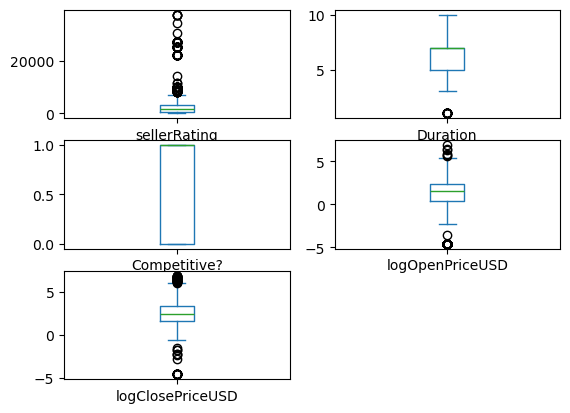

In [25]:
ebay.plot(kind='box', subplots=True, layout=(3,2), sharex=False, sharey=False, legend=False, fontsize=10)

### 3. Data Split into Training and Test Data 

We split the data into training and test sets with a 60%/40% split as suggested in the instruction. The predictors and response variable in our data are:  
 - **Response:** `Competitive?`
 - **Categorical predictors:** `Category`, `Duration`, and `endDay`
 - **Numeric predictors:** `selletRating`, `OpenPriceUSD`, and `ClosePriceUSD`

In [26]:
ebayX = ebay[['Category', 'sellerRating', 'Duration', 'endDay', 'logOpenPriceUSD', 'logClosePriceUSD']]
ebayX.head()

,Category,sellerRating,Duration,endDay,logOpenPriceUSD,logClosePriceUSD
0,Music/Movie/Game,3249,5,Mon,-4.60517,-4.60517
1,Music/Movie/Game,3249,5,Mon,-4.60517,-4.60517
2,Music/Movie/Game,3249,5,Mon,-4.60517,-4.60517
3,Music/Movie/Game,3249,5,Mon,-4.60517,-4.60517
4,Music/Movie/Game,3249,5,Mon,-4.60517,-4.60517


In [27]:
ebayY = ebay['Competitive?']
ebayY.head()

0    0
1    0
2    0
3    0
4    0
Name: Competitive?, dtype: int64

In [28]:
# Set a seed for reproducibility
seed = 42
test_size = 0.40

In [29]:
X_train, X_test, y_train, y_test = train_test_split(ebayX, ebayY, test_size=test_size, random_state=seed)

In [30]:
X_train.shape

(1183, 6)

In [31]:
y_train.shape

(1183,)

In [32]:
X_test.shape

(789, 6)

In [33]:
y_test.shape

(789,)

### 4. Data Preprocessing: OneHotEncoding and Standardization

We have identified that there are some categorical predictors in our data and we have to apply `OneHotEncoding`, where we create dummy variables for each categories inside of a categorical predictor. Since we are fitting a KNN model, which is very sensitive to the scales of numeric data, we also have to apply the standardization on numeric predictors. To perform the transformations on numeric and categorical columns separately, we will use a `ColumnTransformer`. Then we will wrap the transformations in a `pipeline` so that we are only fitting the transformers on training data and applying the transformations on training and test data so that we can avoid data leakage problems.

In [34]:
# Store the column names of categorical and numeric predictors
categorical_predictors = ['Category', 'Duration', 'endDay']
numeric_predictors = ['sellerRating', 'logOpenPriceUSD', 'logClosePriceUSD']

In [35]:
# Define the ColumnTransformer and specify which columns they will touch
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_predictors),
    ("categorical", OneHotEncoder(handle_unknown="ignore", drop=None), categorical_predictors)
])

In [36]:
# Make a pipeline that will apply the ColumnTransformer and fit the KNN model
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier())
])

### 5. K-Fold Cross Validation

Now we can use k-fold Cross Validation to find the best value of k for our KNN model. Since this is a classification problem, we are using `accuracy` as the scoring method when comparing the performance of KNN models with different values of k. The `accuracy` measures the fraction of correct predictions by our model.

In [37]:
# Defining the parameters in k-fold CV
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
k_values = np.arange(1, 20)
param_grid = {"knn__n_neighbors": k_values}

In [38]:
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=kfold, scoring='accuracy')

In [39]:
grid_result = grid.fit(X_train, y_train)

In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.774227 using {'knn__n_neighbors': np.int64(4)}


In [41]:
means = grid_result.cv_results_["mean_test_score"]

Text(0, 0.5, 'Accuracy')

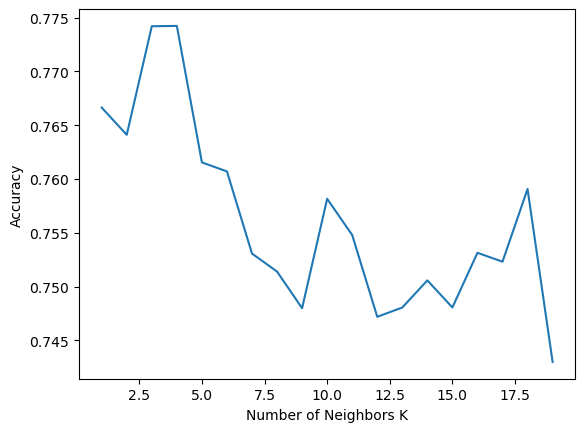

In [42]:
plt.plot(k_values, means)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")

### 6. Fitting the KNN Classifier with the Best k Value

From the cross validation above, we have found that the best value of k when fitting the KNN classifier on our data is at `k = 4`.

In [43]:
pipe_best_knn = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsClassifier(n_neighbors=4))
])

In [44]:
pipe_best_knn.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
estimates = pipe_best_knn.predict(X_test)

### 7. Evaluating the KNN Classifier on Test Data

We can evaluate how well does our KNN model predict the test data by checking its accuracy score, which represents the proportion of correct predictions on test data, and the confusion matrix.

In [46]:
acc = accuracy_score(y_test, estimates)
print("Accuracy:", acc)

Accuracy: 0.743979721166033


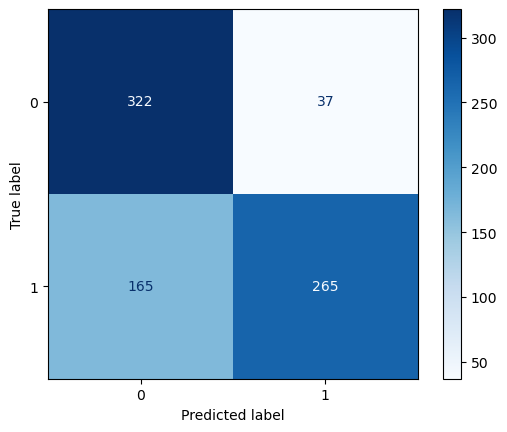

In [47]:
cm = confusion_matrix(y_test, estimates)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_best_knn.classes_)
cm_display.plot(cmap="Blues")